In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import h5py
import sys
sys.path.append('./../data/')
from makeCorner import *
sys.path.append("./../code/")
from piCurve import *
from gwBackground import *
from makeDelayedRateData import *
import tqdm
from astropy.cosmology import Planck18
import astropy.units as u
import matplotlib.cm as cm
import population_parameters

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

In [2]:
# Load in data
data = h5py.File("./../data/fixed_rate_uniform.hdf","r")

kappa_dcs = data['result']['kappa_dcs_2D'][()]
kappa_zs = data['result']['kappa_zs_2D'][()]
joint_probabilities = data['result']['probabilities'][()]

In [3]:
# Now prepare a grid of redshifts and (arbitrarily normalized) merger rate values.
# In this case, our model is a flat merger rate per comoving volume
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
dRdV_uniform = np.ones(zs_merger.size)
dRdV_uniform[zs_merger>6] = 0

# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

# Define hyperparameters describing mass distribution
R0 = population_parameters.R0
m_min = population_parameters.m_min
m_max = population_parameters.m_max
dm_min = population_parameters.dm_min
dm_max = population_parameters.dm_max
alpha = population_parameters.alpha_m
mu_peak = population_parameters.mu_peak
sig_peak = population_parameters.sig_peak
frac_peak = population_parameters.frac_peak
bq = population_parameters.bq

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,dm_min,dm_max,alpha,mu_peak,sig_peak,frac_peak,bq)

/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/./../code/gwBackground.py:352: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-2.**(1.+bq))


In [4]:
# Prepare arrays with the kappa_d vs. kappa_z coordinates for every computed posterior probability
KZ,KD = np.meshgrid(kappa_zs,kappa_dcs)
full_kappa_ds = KD.reshape(-1)
full_kappa_zs = KZ.reshape(-1)

# Unwrap joint probabilities into a corresponding 1D array
full_probabilities = joint_probabilities.reshape(-1)/np.max(joint_probabilities)

# We will use this array to keep track of which grid points we wish to keep, upon rejection sampling
to_save = np.full(full_kappa_ds.size,False)

# Loop across each grid point
from tqdm.notebook import tqdm
for i in tqdm(range(full_kappa_ds.size)):
    
    # Draw and random number; if this does not exceed posterior at the given location,
    # keep this sample
    if np.random.random()<full_probabilities[i]:
        to_save[i]=True
        
# Read out rejection-sampled points
selected_kappa_ds = full_kappa_ds[to_save]        
selected_kappa_zs = full_kappa_zs[to_save]

  0%|          | 0/159600 [00:00<?, ?it/s]

In [5]:
nDraws = 1000
freqs = np.logspace(1,3.5,300)
OmgIs = np.zeros((nDraws,freqs.size))
OmgVs = np.zeros((nDraws,freqs.size))

random_inds = np.random.choice(range(selected_kappa_ds.size),size=nDraws)
for i,ind in tqdm(enumerate(random_inds)):
    
    OmgI,OmgV = omg.eval(R0,dRdV_uniform,freqs,selected_kappa_ds[ind],selected_kappa_zs[ind])
    OmgIs[i,:] = OmgI
    OmgVs[i,:] = OmgV

0it [00:00, ?it/s]

In [6]:
PI_freqs,StokesI_PI = stokes_I_PI()
PI_freqs,StokesV_PI = stokes_V_PI()

/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/./../code/piCurve.py:78: RuntimeWarning: divide by zero encountered in divide
  full_sigmas = 1./np.sqrt(inv_full_sigmas_squared)
/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/./../code/piCurve.py:166: RuntimeWarning: divide by zero encountered in divide
  full_sigmas = 1./np.sqrt(inv_full_sigmas_squared)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


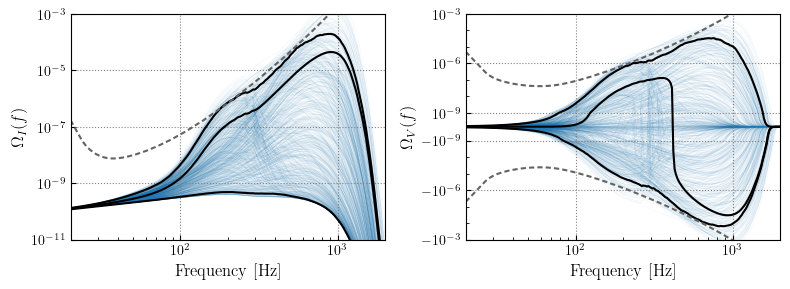

In [7]:
fig,axs = plt.subplots(1,2,figsize=(8,3))

ax = axs[0]
ax.set_rasterization_zorder(1)
for i in range(nDraws):
    ax.plot(freqs,OmgIs[i,:],color=blue,lw=0.2,alpha=0.1,zorder=0)
ax.plot(freqs,np.mean(OmgIs,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgIs,0.95,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgIs,0.05,axis=0),color='black')

ax.plot(PI_freqs,StokesI_PI,color='#636363',dashes=(2.5,1.5))

ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('$\Omega_I(f)$')
ax.set_xlim(20,2000)
ax.set_ylim(1e-11,1e-3)

ax = axs[1]
ax.set_rasterization_zorder(1)
for i in range(nDraws):
    ax.plot(freqs,OmgVs[i,:],color=blue,lw=0.2,alpha=0.1,zorder=0)
ax.plot(freqs,np.mean(OmgVs,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgVs,0.95,axis=0),color='black')
ax.plot(freqs,np.quantile(OmgVs,0.05,axis=0),color='black')

ax.plot(PI_freqs,StokesV_PI,color='#636363',dashes=(2.5,1.5))
ax.plot(PI_freqs,-StokesV_PI,color='#636363',dashes=(2.5,1.5))

ax.set_xscale('log')
ax.set_yscale('symlog',linthresh=1e-9,linscale=0.75)
ax.set_xlim(20,2000)
ax.set_ylim(-1e-3,1e-3)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('$\Omega_V(f)$')
ax.set_yticks([-1e-3,-1e-6,-1e-9,1e-9,1e-6,1e-3])

plt.tight_layout()
plt.savefig('figure_05.pdf',bbox_inches='tight',dpi=200)
plt.show()